In [1]:
import blackjack
import cliffwalking
import frozenlake

import argparse
import os

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, CollectStats, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy.base import BasePolicy
from tianshou.policy.modelfree.discrete_sac import DiscreteSACTrainingStats, DiscreteSACPolicy
import tianshou.policy.modelfree.discrete_sac as dsac
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.space_info import SpaceInfo


%load_ext autoreload
%autoreload 2

In [2]:
envs_names = ["CustomBlackjack-v0", "CustomCliffWalking-v0", "FrozenLakeCustom-v0"]
reward_threshholds = [500, 500, 500]

def get_args(env_idx) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default=envs_names[env_idx])
    parser.add_argument("--reward-threshold", type=float, default=reward_threshholds[env_idx])
    parser.add_argument("--seed", type=int, default=1)
    parser.add_argument("--buffer-size", type=int, default=20000)
    parser.add_argument("--actor-lr", type=float, default=1e-4)
    parser.add_argument("--critic-lr", type=float, default=1e-3)
    parser.add_argument("--alpha-lr", type=float, default=3e-4)
    parser.add_argument("--gamma", type=float, default=0.95)
    parser.add_argument("--tau", type=float, default=0.005)
    parser.add_argument("--alpha", type=float, default=0.05)
    parser.add_argument("--auto-alpha", action="store_true", default=False)
    parser.add_argument("--epoch", type=int, default=20)
    parser.add_argument("--step-per-epoch", type=int, default=5000)
    parser.add_argument("--step-per-collect", type=int, default=10)
    parser.add_argument("--update-per-step", type=float, default=0.1)
    parser.add_argument("--batch-size", type=int, default=128)
    parser.add_argument("--hidden-sizes", type=int, nargs="*", default=[64, 64])
    parser.add_argument("--training-num", type=int, default=10)
    parser.add_argument("--test-num", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.0)
    parser.add_argument("--n-step", type=int, default=3)
    parser.add_argument(
        "--device",
        type=str,
        default="cuda" if torch.cuda.is_available() else "cpu",
    )
    return parser.parse_known_args()[0]


In [3]:
def train(env_idx):
    args: argparse.Namespace = get_args(env_idx)
    dsac.RESULTS_ALPHA_LOSS = []
    dsac.RESULTS_CRITIC1 = []
    dsac.RESULTS_CRITIC2 = []
    dsac.RESULTS_ACTOR = []
    
    env = gym.make(args.task)
    assert isinstance(env.action_space, gym.spaces.Discrete)
    space_info = SpaceInfo.from_env(env)
    args.state_shape = space_info.observation_info.obs_shape
    args.action_shape = space_info.action_info.action_shape
    if args.reward_threshold is None:
        default_reward_threshold = {"RandomWalk-v0": 170}  # lower the goal
        args.reward_threshold = default_reward_threshold.get(
            args.task,
            env.spec.reward_threshold if env.spec else None,
        )
    train_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)
    # model
    obs_dim = space_info.observation_info.obs_dim
    action_dim = space_info.action_info.action_dim
    net = Net(state_shape=args.state_shape, hidden_sizes=args.hidden_sizes, device=args.device)
    actor = Actor(net, args.action_shape, softmax_output=False, device=args.device).to(args.device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    net_c1 = Net(state_shape=args.state_shape, hidden_sizes=args.hidden_sizes, device=args.device)
    critic1 = Critic(net_c1, last_size=action_dim, device=args.device).to(args.device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    net_c2 = Net(obs_dim, hidden_sizes=args.hidden_sizes, device=args.device)
    critic2 = Critic(net_c2, last_size=action_dim, device=args.device).to(args.device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)

    # better not to use auto alpha in CartPole
    if args.auto_alpha:
        target_entropy = 0.98 * np.log(action_dim)
        log_alpha = torch.zeros(1, requires_grad=True, device=args.device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    policy: DiscreteSACPolicy[DiscreteSACTrainingStats] = DiscreteSACPolicy(
        actor=actor,
        actor_optim=actor_optim,
        critic=critic1,
        action_space=env.action_space,
        critic_optim=critic1_optim,
        critic2=critic2,
        critic2_optim=critic2_optim,
        tau=args.tau,
        gamma=args.gamma,
        alpha=args.alpha,
        estimation_step=args.n_step,
    )
    # collector
    train_collector = Collector[CollectStats](
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
    )
    test_collector = Collector[CollectStats](policy, test_envs)
    # train_collector.collect(n_step=args.buffer_size)
    # log
    log_path = os.path.join(args.logdir, args.task, "discrete_sac")
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)

    def stop_fn(mean_rewards: float) -> bool:
        return mean_rewards >= args.reward_threshold
    
    # trainer
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=args.epoch,
        step_per_epoch=args.step_per_epoch,
        step_per_collect=args.step_per_collect,
        episode_per_test=args.test_num,
        batch_size=args.batch_size,
        stop_fn=stop_fn,
        logger=logger,
        update_per_step=args.update_per_step,
        test_in_train=False,
    ).run()
    return dsac.RESULTS_ACTOR.copy(), dsac.RESULTS_CRITIC1.copy(), dsac.RESULTS_CRITIC2.copy(), dsac.RESULTS_ALPHA_LOSS.copy()

In [4]:
results_actor = []
results_critic1 = []
results_critic2 = []
results_alpha_loss = []

for i in range(len(envs_names)):
    results = train(i)
    results_actor.append(results[0])
    results_critic1.append(results[1])
    results_critic2.append(results[2])
    results_alpha_loss.append(results[3])



                                                                        Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error

Epoch #1: test_reward: -0.130000 ± 0.955563, best_reward: -0.130000 ± 0.955563 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #2: 5001it [00:18, 265.74it/s, env_episode=8860, env_step=10000, gradient_step=1000, len=1, n/ep=9, n/st=10, rew=-0.11]                          


Epoch #2: test_reward: -0.140000 ± 0.959375, best_reward: -0.130000 ± 0.955563 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #3: 5001it [00:22, 223.43it/s, env_episode=12740, env_step=15000, gradient_step=1500, len=1, n/ep=8, n/st=10, rew=0.25]                          


Epoch #3: test_reward: 0.050000 ± 0.952628, best_reward: 0.050000 ± 0.952628 in #3


Epoch #4: 5001it [00:24, 205.64it/s, env_episode=16472, env_step=20000, gradient_step=2000, len=1, n/ep=6, n/st=10, rew=-0.33]                          


Epoch #4: test_reward: 0.030000 ± 0.974218, best_reward: 0.050000 ± 0.952628 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #5: 5001it [00:25, 192.51it/s, env_episode=20070, env_step=25000, gradient_step=2500, len=1, n/ep=9, n/st=10, rew=-0.44]                          


Epoch #5: test_reward: -0.030000 ± 0.984429, best_reward: 0.050000 ± 0.952628 in #3


Epoch #6: 5001it [00:28, 174.10it/s, env_episode=23545, env_step=30000, gradient_step=3000, len=1, n/ep=6, n/st=10, rew=0.17]                          


Epoch #6: test_reward: 0.080000 ± 0.966230, best_reward: 0.080000 ± 0.966230 in #6


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #7: 5001it [00:27, 179.32it/s, env_episode=26976, env_step=35000, gradient_step=3500, len=1, n/ep=9, n/st=10, rew=0.44]                          


Epoch #7: test_reward: -0.020000 ± 0.979592, best_reward: 0.080000 ± 0.966230 in #6


Epoch #8: 5001it [00:28, 175.60it/s, env_episode=30324, env_step=40000, gradient_step=4000, len=1, n/ep=6, n/st=10, rew=0.00]                          


Epoch #8: test_reward: -0.020000 ± 0.948472, best_reward: 0.080000 ± 0.966230 in #6


Epoch #9: 5001it [00:28, 176.46it/s, env_episode=33653, env_step=45000, gradient_step=4500, len=1, n/ep=8, n/st=10, rew=0.62]                          


Epoch #9: test_reward: 0.060000 ± 0.957288, best_reward: 0.080000 ± 0.966230 in #6


Epoch #10: 5001it [00:28, 178.04it/s, env_episode=36917, env_step=50000, gradient_step=5000, len=2, n/ep=8, n/st=10, rew=0.12]                          


Epoch #10: test_reward: -0.030000 ± 0.963898, best_reward: 0.080000 ± 0.966230 in #6


Epoch #11: 5001it [00:27, 181.08it/s, env_episode=40223, env_step=55000, gradient_step=5500, len=1, n/ep=7, n/st=10, rew=0.71]                          


Epoch #11: test_reward: -0.100000 ± 0.943398, best_reward: 0.080000 ± 0.966230 in #6


Epoch #12: 5001it [00:25, 195.97it/s, env_episode=43582, env_step=60000, gradient_step=6000, len=1, n/ep=7, n/st=10, rew=0.29]                          


Epoch #12: test_reward: 0.000000 ± 0.938083, best_reward: 0.080000 ± 0.966230 in #6


Epoch #13: 5001it [00:26, 186.44it/s, env_episode=46871, env_step=65000, gradient_step=6500, len=1, n/ep=6, n/st=10, rew=-1.00]                          


Epoch #13: test_reward: -0.020000 ± 0.958958, best_reward: 0.080000 ± 0.966230 in #6


Epoch #14: 5001it [00:27, 183.84it/s, env_episode=50233, env_step=70000, gradient_step=7000, len=1, n/ep=9, n/st=10, rew=-0.56]                          


Epoch #14: test_reward: -0.120000 ± 0.972420, best_reward: 0.080000 ± 0.966230 in #6


Epoch #15: 5001it [00:27, 182.46it/s, env_episode=53523, env_step=75000, gradient_step=7500, len=1, n/ep=6, n/st=10, rew=0.17]                          


Epoch #15: test_reward: 0.020000 ± 0.948472, best_reward: 0.080000 ± 0.966230 in #6


Epoch #16: 5001it [00:28, 175.60it/s, env_episode=56849, env_step=80000, gradient_step=8000, len=2, n/ep=6, n/st=10, rew=-0.17]                          


Epoch #16: test_reward: 0.000000 ± 0.959166, best_reward: 0.080000 ± 0.966230 in #6


Epoch #17: 5001it [00:28, 175.52it/s, env_episode=60159, env_step=85000, gradient_step=8500, len=1, n/ep=7, n/st=10, rew=0.57]                          


Epoch #17: test_reward: 0.050000 ± 0.942072, best_reward: 0.080000 ± 0.966230 in #6


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #18: 5001it [00:28, 177.41it/s, env_episode=63442, env_step=90000, gradient_step=9000, len=1, n/ep=8, n/st=10, rew=0.12]                          


Epoch #18: test_reward: -0.120000 ± 0.919565, best_reward: 0.080000 ± 0.966230 in #6


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #19: 5001it [00:27, 181.38it/s, env_episode=66775, env_step=95000, gradient_step=9500, len=2, n/ep=5, n/st=10, rew=-0.40]                          


Epoch #19: test_reward: 0.050000 ± 0.963068, best_reward: 0.080000 ± 0.966230 in #6


Epoch #20: 5001it [00:27, 182.69it/s, env_episode=70041, env_step=100000, gradient_step=10000, len=1, n/ep=7, n/st=10, rew=-0.29]                          


Epoch #20: test_reward: -0.200000 ± 0.938083, best_reward: 0.080000 ± 0.966230 in #6


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #2: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #3: 5001it [00:23, 214.79it/s, env_episode=30, env_step=15000, gradient_step=1500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #3: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #4: 5001it [00:25, 193.99it/s, env_episode=40, env_step=20000, gradient_step=2000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #4: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #5: 5001it [00:28, 174.92it/s, env_episode=50, env_step=25000, gradient_step=2500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #5: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #6: 5001it [00:30, 166.35it/s, env_episode=60, env_step=30000, gradient_step=3000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #6: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #7: 5001it [00:28, 176.54it/s, env_episode=70, env_step=35000, gradient_step=3500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #7: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #8: 5001it [00:26, 187.03it/s, env_episode=80, env_step=40000, gradient_step=4000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #8: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #9: 5001it [00:29, 172.22it/s, env_episode=90, env_step=45000, gradient_step=4500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #9: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #10: 5001it [00:28, 174.61it/s, env_episode=100, env_step=50000, gradient_step=5000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #10: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #11: 5001it [00:25, 195.76it/s, env_episode=110, env_step=55000, gradient_step=5500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #11: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #12: 5001it [00:25, 193.44it/s, env_episode=120, env_step=60000, gradient_step=6000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #12: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #13: 5001it [00:25, 196.64it/s, env_episode=130, env_step=65000, gradient_step=6500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #13: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #14: 5001it [00:28, 175.05it/s, env_episode=140, env_step=70000, gradient_step=7000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #14: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #15: 5001it [00:32, 155.09it/s, env_episode=150, env_step=75000, gradient_step=7500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #15: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #16: 5001it [00:27, 180.59it/s, env_episode=160, env_step=80000, gradient_step=8000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #16: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #17: 5001it [00:29, 169.23it/s, env_episode=170, env_step=85000, gradient_step=8500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #17: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #18: 5001it [00:27, 180.89it/s, env_episode=180, env_step=90000, gradient_step=9000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #18: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #19: 5001it [00:28, 176.43it/s, env_episode=190, env_step=95000, gradient_step=9500, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #19: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


Epoch #20: 5001it [00:27, 183.82it/s, env_episode=200, env_step=100000, gradient_step=10000, len=500, n/ep=10, n/st=10, rew=-500.00]                          


Epoch #20: test_reward: -500.000000 ± 0.000000, best_reward: -500.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0


Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collec

Epoch #2: test_reward: 0.460000 ± 0.498397, best_reward: 0.460000 ± 0.498397 in #2


Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collec

Epoch #3: test_reward: 0.860000 ± 0.346987, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #4: test_reward: 0.700000 ± 0.458258, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #5: test_reward: 0.280000 ± 0.448999, best_reward: 0.860000 ± 0.346987 in #3


Epoch #6: 5001it [00:20, 247.71it/s, env_episode=3326, env_step=30000, gradient_step=3000, len=6, n/ep=0, n/st=10, rew=0.00]                          


Epoch #6: test_reward: 0.240000 ± 0.427083, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #7: test_reward: 0.220000 ± 0.414246, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #8: 5001it [00:19, 253.51it/s, env_episode=4380, env_step=40000, gradient_step=4000, len=8, n/ep=0, n/st=10, rew=0.00]                          


Epoch #8: test_reward: 0.510000 ± 0.499900, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #9: 5001it [00:18, 263.46it/s, env_episode=4871, env_step=45000, gradient_step=4500, len=3, n/ep=1, n/st=10, rew=0.00]                          


Epoch #9: test_reward: 0.760000 ± 0.427083, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #10: test_reward: 0.740000 ± 0.438634, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #11: 5001it [00:19, 251.08it/s, env_episode=5868, env_step=55000, gradient_step=5500, len=4, n/ep=1, n/st=10, rew=0.00]                          


Epoch #11: test_reward: 0.340000 ± 0.473709, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch 

Epoch #12: test_reward: 0.780000 ± 0.414246, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #13: test_reward: 0.680000 ± 0.466476, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #14: test_reward: 0.240000 ± 0.427083, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #15: 5001it [00:22, 217.58it/s, env_episode=7798, env_step=75000, gradient_step=7500, len=10, n/ep=0, n/st=10, rew=0.00]                      

Epoch #15: test_reward: 0.740000 ± 0.438634, best_reward: 0.860000 ± 0.346987 in #3


Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collec

Epoch #16: test_reward: 0.800000 ± 0.400000, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #17: test_reward: 0.700000 ± 0.458258, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #18: 5001it [00:22, 227.19it/s, env_episode=9255, env_step=90000, gradient_step=9000, len=12, n/ep=3, n/st=10, rew=0.33]                      

Epoch #18: test_reward: 0.560000 ± 0.496387, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #19: 5001it [00:19, 257.87it/s, env_episode=9740, env_step=95000, gradient_step=9500, len=5, n/ep=2, n/st=10, rew=0.00]                          


Epoch #19: test_reward: 0.780000 ± 0.414246, best_reward: 0.860000 ± 0.346987 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #20: 5001it [00:20, 247.32it/s, env_episode=10246, env_step=100000, gradient_step=10000, len=8, n/ep=0, n/st=10, rew=0.00]                          


Epoch #20: test_reward: 0.670000 ± 0.470213, best_reward: 0.860000 ± 0.346987 in #3


In [5]:
print(results_actor)

[[[-0.1490454524755478, 0.14907389879226685, -0.0001963191170943901, -1.4201724529266357, 0.012554105371236801], [-0.1490454524755478, 0.14917324483394623, -0.00019814081315416843, -1.433350682258606, 0.024839820340275764], [-0.1490454524755478, 0.14925402402877808, -0.00020009449508506805, -1.4474835395812988, 0.03385518491268158], [-0.1490454524755478, 0.14934195578098297, -0.00020139678963460028, -1.456904411315918, 0.04130522161722183], [-0.1490454524755478, 0.1494317352771759, -0.0002029835741268471, -1.4683831930160522, 0.05035912245512009], [-0.1490454524755478, 0.1495228409767151, -0.00020455093181226403, -1.4797214269638062, 0.05539027974009514], [-0.1490454524755478, 0.14955782890319824, -0.00020742784545291215, -1.5005329847335815, 0.06246566027402878], [-0.1490454524755478, 0.14957524836063385, -0.0002111052453983575, -1.5271353721618652, 0.06836073100566864], [-0.1490454524755478, 0.14958035945892334, -0.00021558263688348234, -1.5595247745513916, 0.07531371712684631], [-0.

In [6]:
from scipy.ndimage import gaussian_filter1d
def smooth_curve(data, sigma=2):
    data = np.array(data)
    return gaussian_filter1d(data, sigma=sigma)

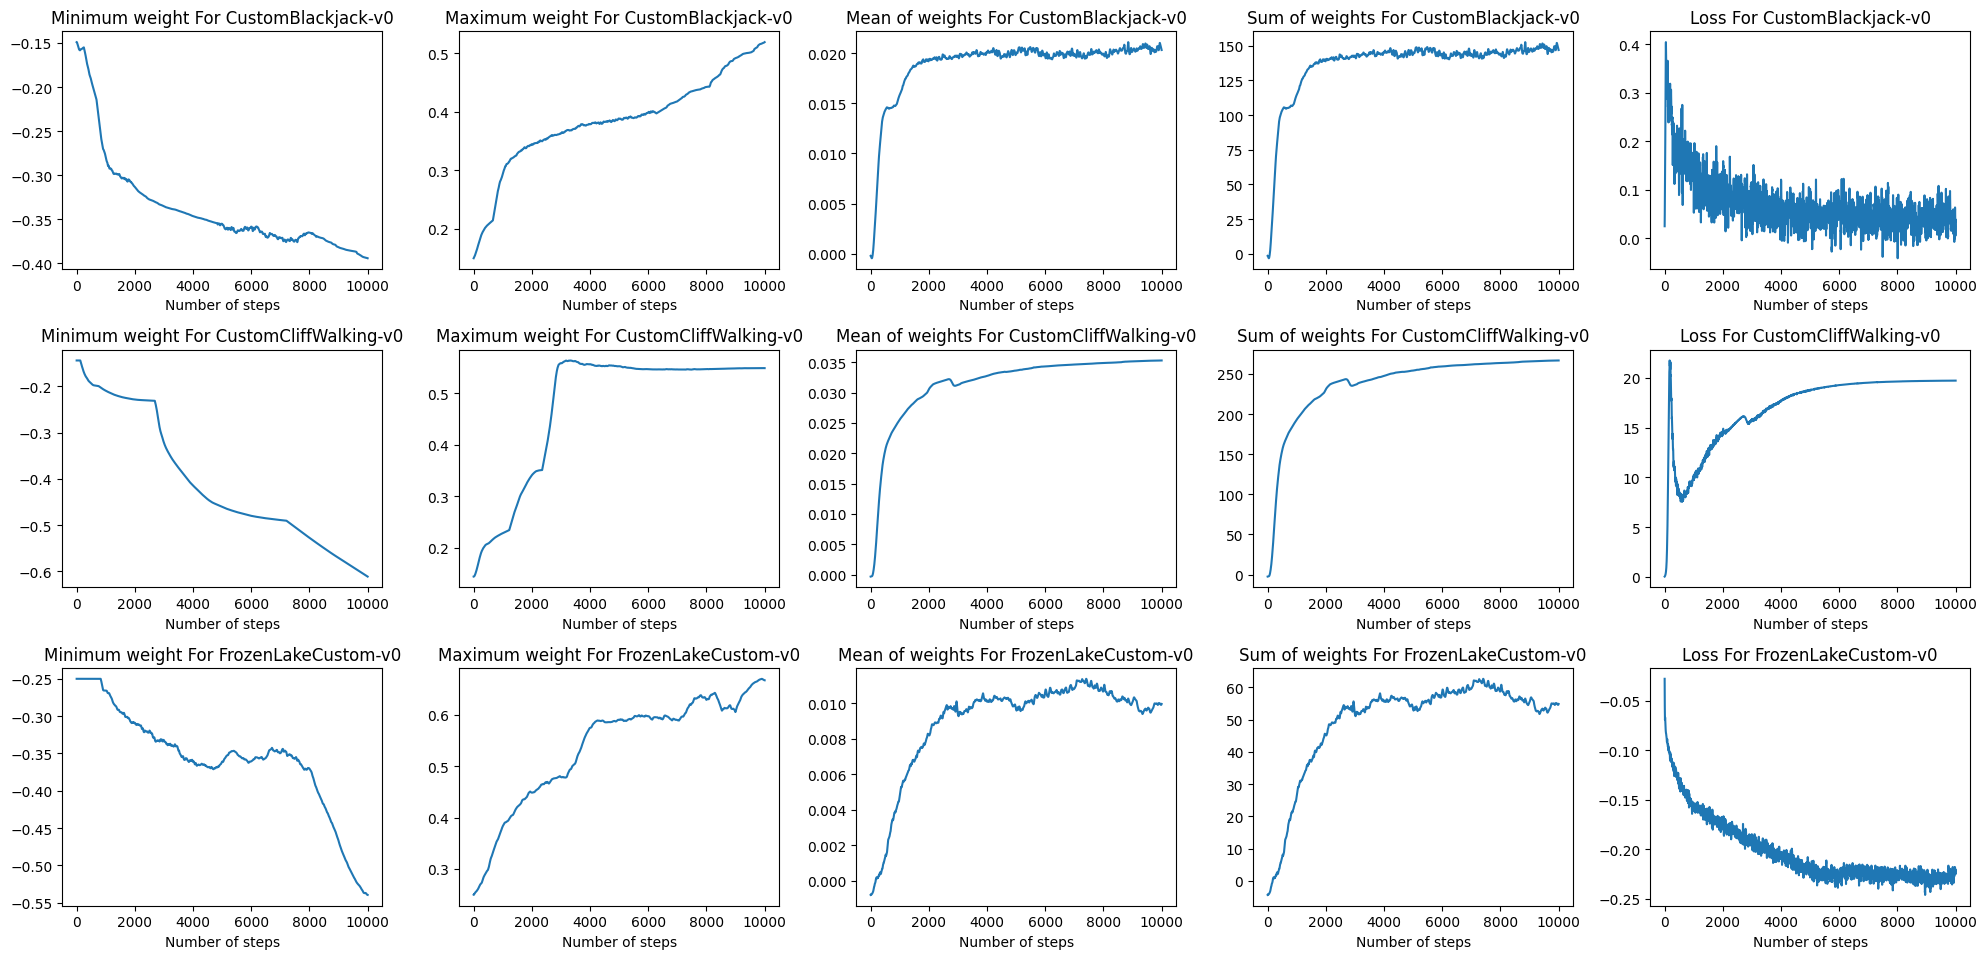

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def plot_3x5_subplots(results, labels=None):
    """
    Plot a 3x5 grid of subplots using data from a 3D array.

    Parameters:
    - results: 3x5 list/array where results[i][j] contains (x, y1, y2, ..., yn) data for subplot[i][j]
    - titles: Optional 3x5 list of titles for each subplot
    - labels: Optional list of labels for each line in the plots (used in legends per column)
    """

    fig, axes = plt.subplots(3, 5, figsize=(20, 10), sharex=False, sharey=False)

    for i in range(3):
        data = results[i]
        data = np.array(data).T
        for j in range(5):
            ax = axes[i][j]
            if j == 4:
                data[j] = smooth_curve(data[j])
            ax.plot(data[j], label=labels[j])

            title = labels[j] + " For " + envs_names[i]
            ax.set_title(title)
            ax.set_xlabel("Number of steps")


    # # Add shared legends per column
    # for j in range(5):
    #     handles, legend_labels = axes[0][j].get_legend_handles_labels()
    #     if handles:
    #         fig.legend(handles, legend_labels, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=(0.1 + j * 0.18, 1.03))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Line labels
labels = ["Minimum weight", "Maximum weight", "Mean of weights", "Sum of weights", "Loss"]

plot_3x5_subplots(results_actor, labels)

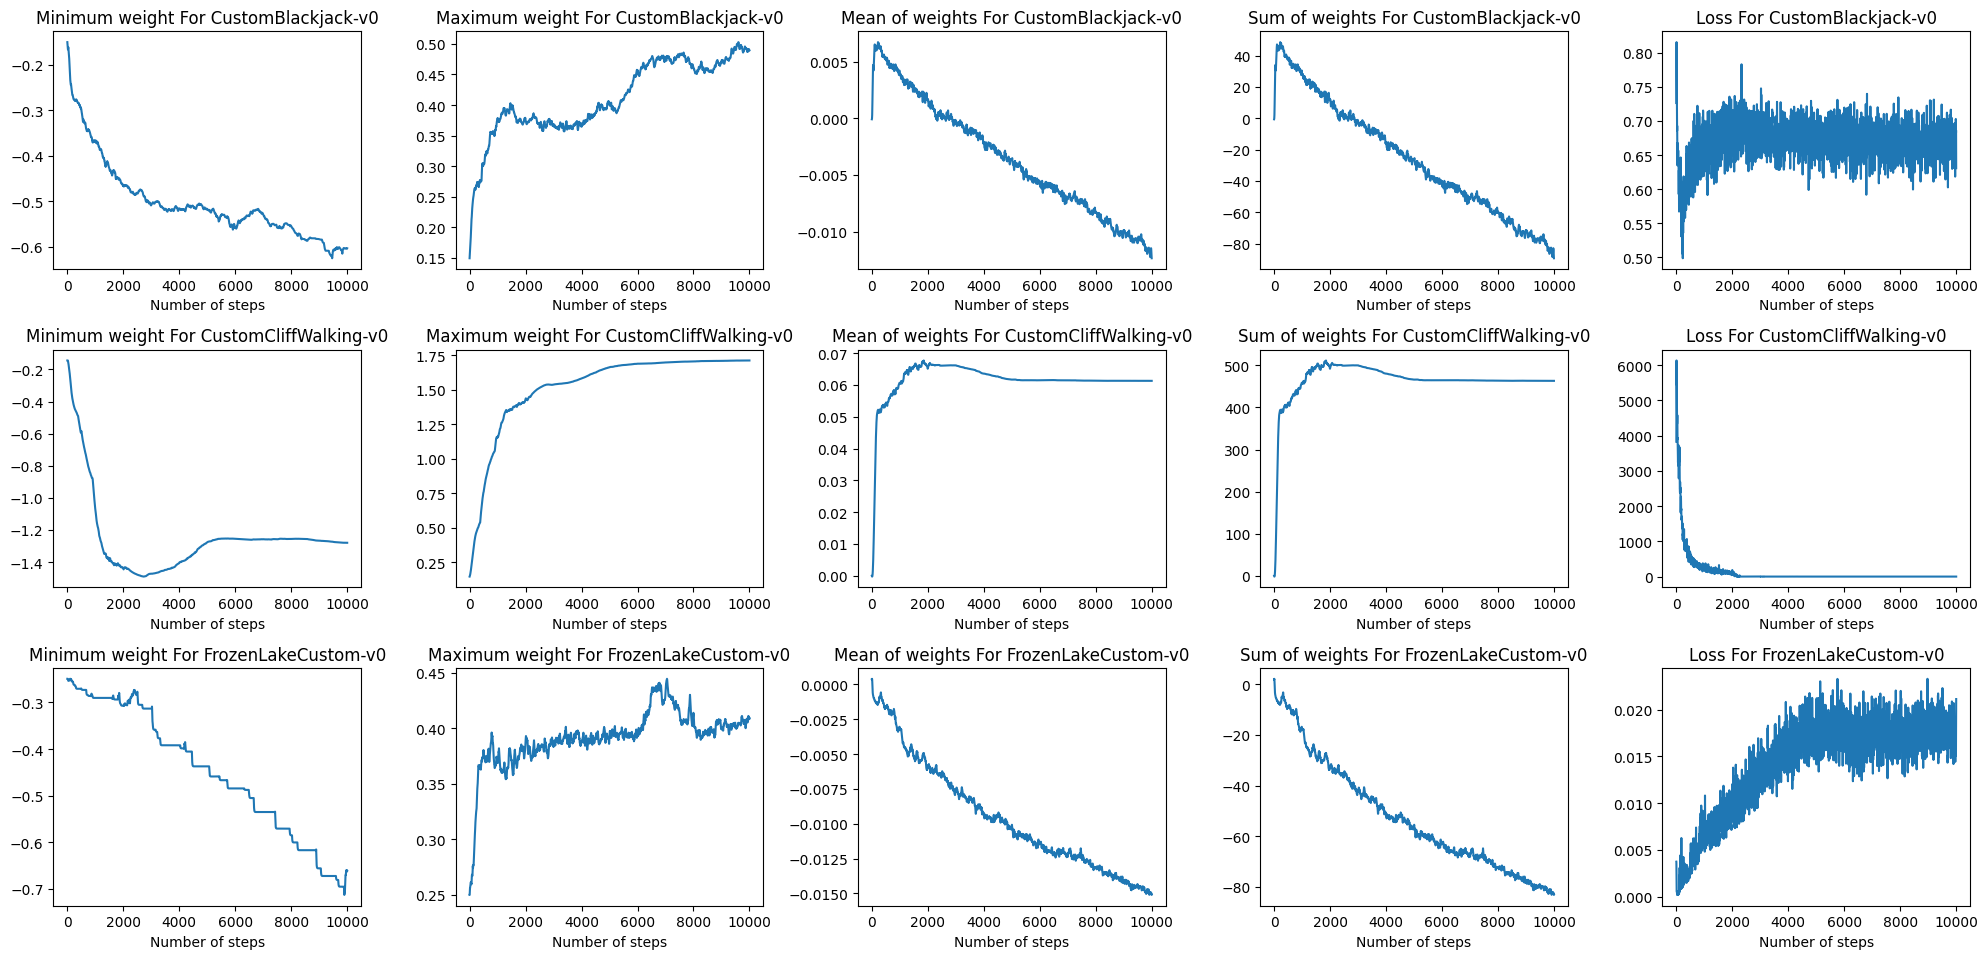

In [8]:
plot_3x5_subplots(results_critic1, labels)

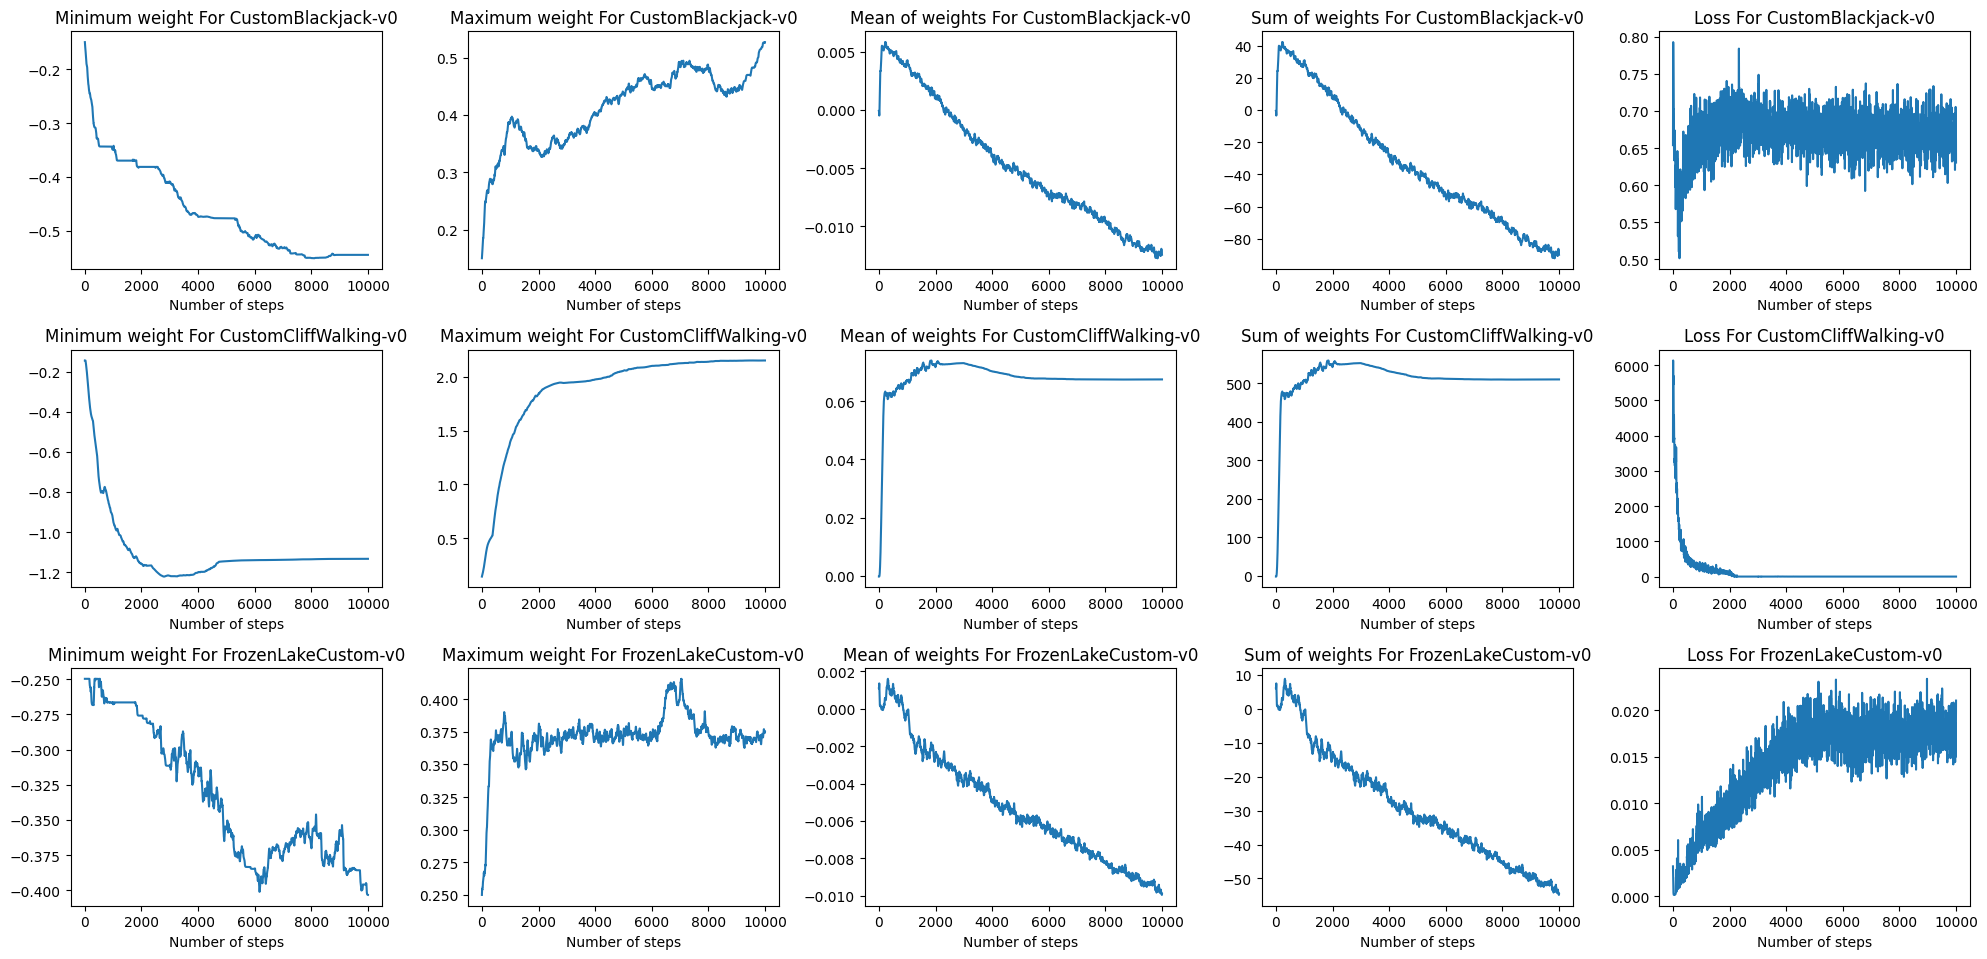

In [9]:
plot_3x5_subplots(results_critic2, labels)